# Model

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from pmf import PMFModel, ModelHyperParams
from pmf.initial import InitialModel, simulate_initial_model_params
from pmf.vi import CaviParams

from utils import evaluation
from utils.logger import Logger

In [2]:
# Model hyperparameters
hyperparams = ModelHyperParams(
    num_features=3,
    a_x=1.0,
    a_y=1.0,
    b_x=1.0,
    b_y=1.0,
    c_x=1.0,
    c_y=1.0,
    alpha_x=1.0,
    alpha_y=1.0,
    beta_x=1.0,
    beta_y=1.0,
)
# Data dimensions
time, N1, N2 = 11, 5, 4

# Set the random seed
rng = np.random.default_rng(43)

# Simulate the initial model parameters
initial_model_params = simulate_initial_model_params(hyperparams, time, N1, N2, rng=rng)

# Create the initial model
initial_model = InitialModel(hyperparams=hyperparams, params=initial_model_params)

# Simulate some data
data = initial_model.simulate_data(rng=rng)

In [3]:
# Split the data into training and test sets
train_data = data[:-1]
all_test_data = data[-1]

print(all_test_data.todense())

[[1 1 1 0]
 [1 1 1 1]
 [1 1 1 0]
 [0 0 0 0]
 [0 0 0 0]]


In [4]:
# Initialize the model
model = PMFModel(
    hyperparams, logger=Logger("PMF Model", log_to_console=True, log_filename="pmf.log")
)

# Fit the model
model.fit(train_data, cavi_params=CaviParams(max_iterations=10))

2024-06-19 10:08:29,425 - INFO - Initializing Parameters...
2024-06-19 10:08:29,839 - INFO - Initialized: Z, N
2024-06-19 10:08:31,025 - INFO - Initialized: X, Y
2024-06-19 10:08:31,025 - INFO - Initialized: Zeta
2024-06-19 10:08:31,075 - INFO - Initialized: Rho
2024-06-19 10:08:31,076 - INFO - All Parameters initialized.

2024-06-19 10:08:31,077 - INFO - Training the model...
2024-06-19 10:08:31,135 - INFO - Iteration 1 - ELBO: -180.29356916808652
2024-06-19 10:08:31,211 - INFO - Iteration 2 - ELBO: -173.5814553129783
2024-06-19 10:08:31,333 - INFO - Iteration 3 - ELBO: -170.408197598093
2024-06-19 10:08:31,475 - INFO - Iteration 4 - ELBO: -168.81907988943013
2024-06-19 10:08:31,636 - INFO - Iteration 5 - ELBO: -167.971087987473
2024-06-19 10:08:31,808 - INFO - Iteration 6 - ELBO: -167.46791349088522
2024-06-19 10:08:31,983 - INFO - Iteration 7 - ELBO: -167.13141522543938
2024-06-19 10:08:32,168 - INFO - Iteration 8 - ELBO: -166.8795696565418
2024-06-19 10:08:32,343 - INFO - Iteration

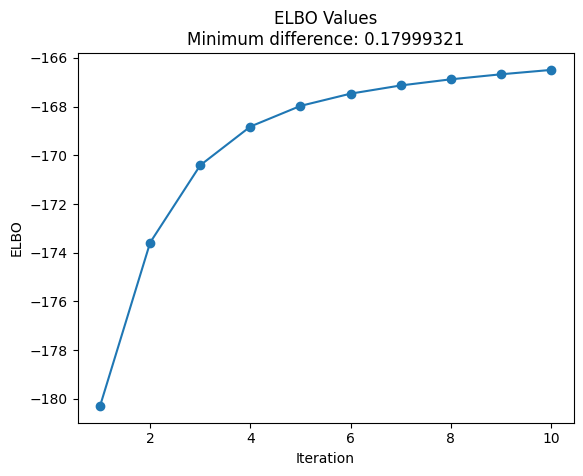

In [5]:
min_diff = np.min(np.diff(model.cavi_results.elbo_values))

# Plot the ELBO values
plt.title(f"ELBO Values\nMinimum difference: {min_diff:.8f}")
plt.plot(model.cavi_results.eval_indices, model.cavi_results.elbo_values)
plt.scatter(model.cavi_results.eval_indices, model.cavi_results.elbo_values)
plt.xlabel("Iteration")
plt.ylabel("ELBO")
plt.show()

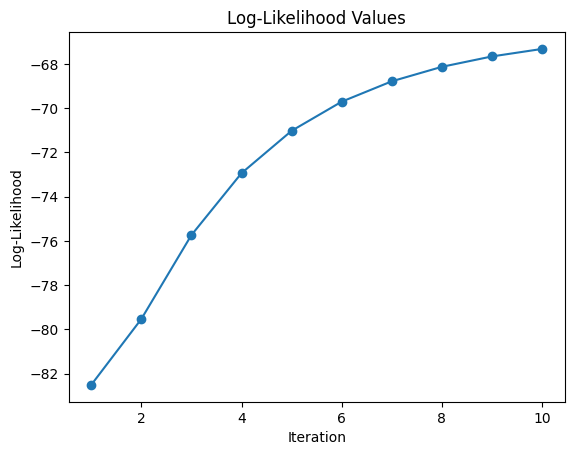

In [6]:
# Plot the log-likelihood values
plt.title("Log-Likelihood Values")
plt.plot(model.cavi_results.eval_indices, model.cavi_results.log_likelihood_values)
plt.scatter(model.cavi_results.eval_indices, model.cavi_results.log_likelihood_values)
plt.xlabel("Iteration")
plt.ylabel("Log-Likelihood")
plt.show()

In [7]:
# Sample indices
indices_axis0, indices_axis1 = evaluation.sample(all_test_data)

# Extract the test data
test_data = all_test_data[indices_axis0, indices_axis1].todense()

# Predict probabilities
probs = model.predict(indices_axis0, indices_axis1)

In [8]:
print("Actual Labels:")
print(test_data)
print("")
print("Predicted Probabilities:")
print(probs)

Actual Labels:
[1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]

Predicted Probabilities:
[0.70186104 0.89281917 0.7467944  0.67311455 0.87347503 0.7189051
 0.1814491  0.537197   0.76463108 0.58286153 0.19499284 0.12770018
 0.24015539 0.40986377 0.26774247 0.04694815 0.311364   0.50733225
 0.34512363 0.06363014]


AUC: 0.93


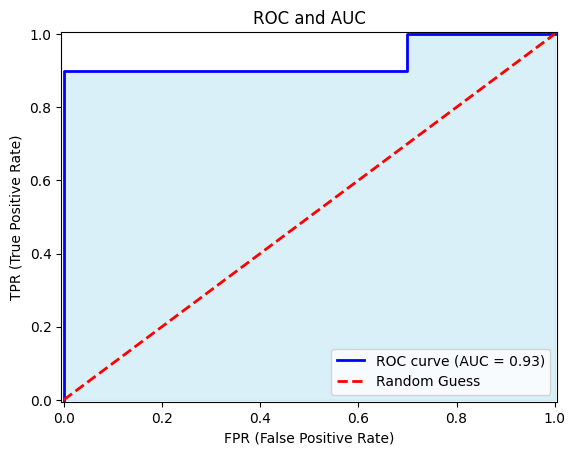

In [9]:
# Evaluate the model
fpr, tpr, auc = evaluation.roc_and_auc(test_data, probs)

print(f"AUC: {auc}")

plt.figure()
plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC curve (AUC = {auc:.2f})")
plt.fill_between(fpr, tpr, alpha=0.3, color="skyblue")
plt.plot([0, 1], [0, 1], color="red", lw=2, linestyle="--", label="Random Guess")

plt.xlim([-0.005, 1.005])
plt.ylim([-0.005, 1.005])
plt.xlabel("FPR (False Positive Rate)")
plt.ylabel("TPR (True Positive Rate)")
plt.title("ROC and AUC")
plt.legend(loc="lower right")
plt.show()